In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import os
import re 

In [2]:
results_directory= '../../model/model_versions/v_6/v_6_2/results/'

output_directory= '../../model/model_versions/v_6/v_6_2/results/'

performance_metrics= pd.read_csv('../../model/model_versions/v_6/v_6_2/results/performance_metrics.csv', index_col=0)

In [3]:
# Example calibration and validation ranges (as you provided)
calibration_ranges = [('1980-10-01', '1984-09-30'),
                      ('1989-10-01', '1998-09-30'),
                      ('2003-10-01', '2007-09-30'),
                      ('2012-10-01', '2015-09-30')]
validation_ranges = [('1984-10-01', '1989-09-30'),
                     ('1998-10-01', '2003-09-30'),
                     ('2007-10-01', '2012-09-30')]

# Convert to datetime for shading
calibration_ranges = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in calibration_ranges]
validation_ranges = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in validation_ranges]

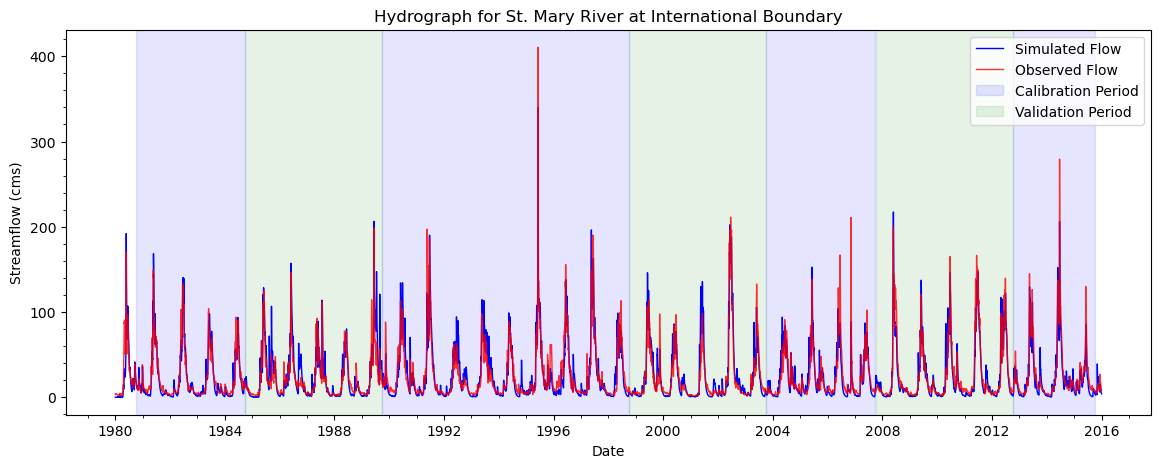

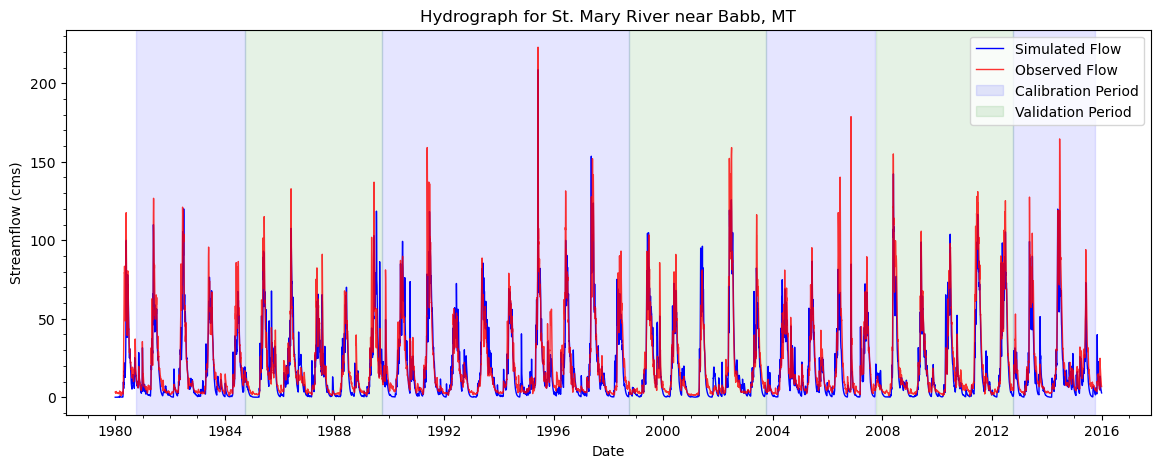

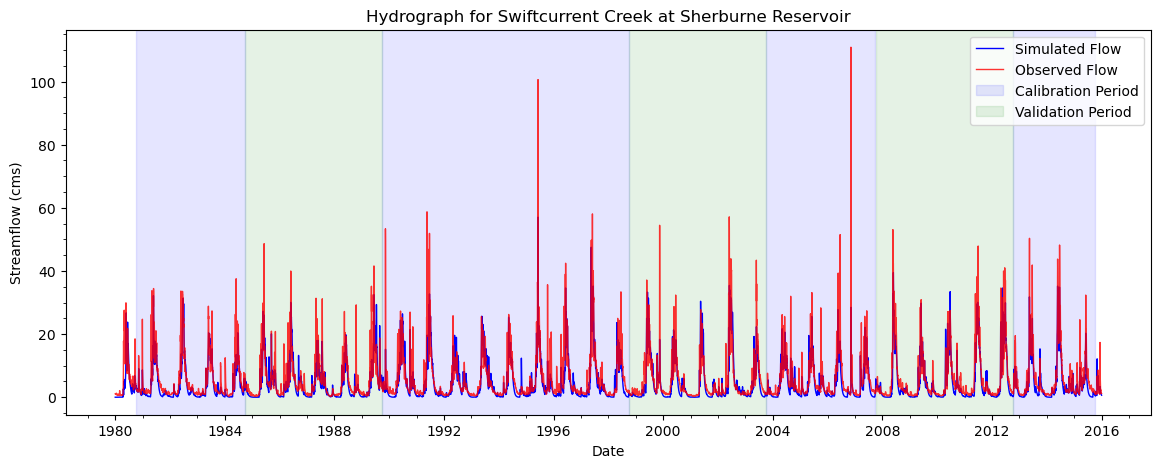

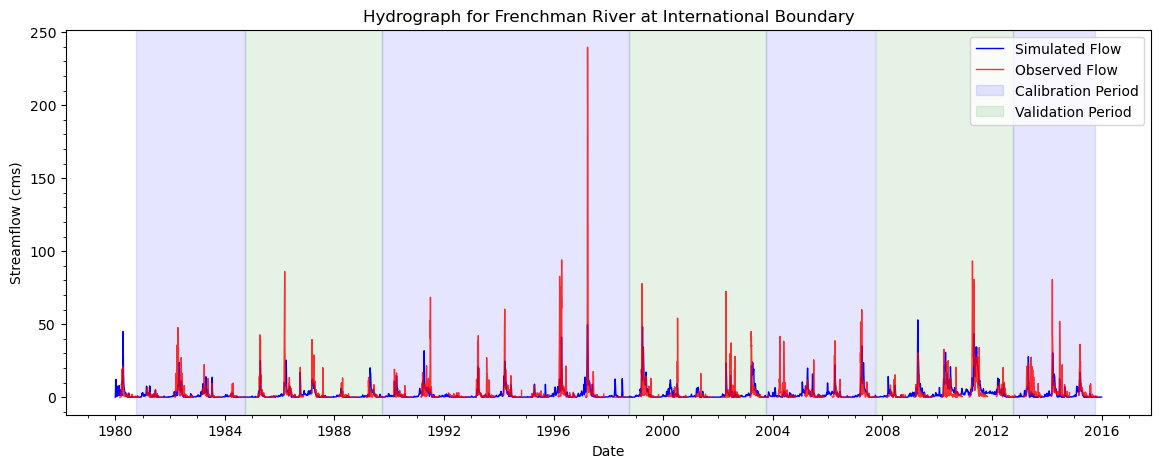

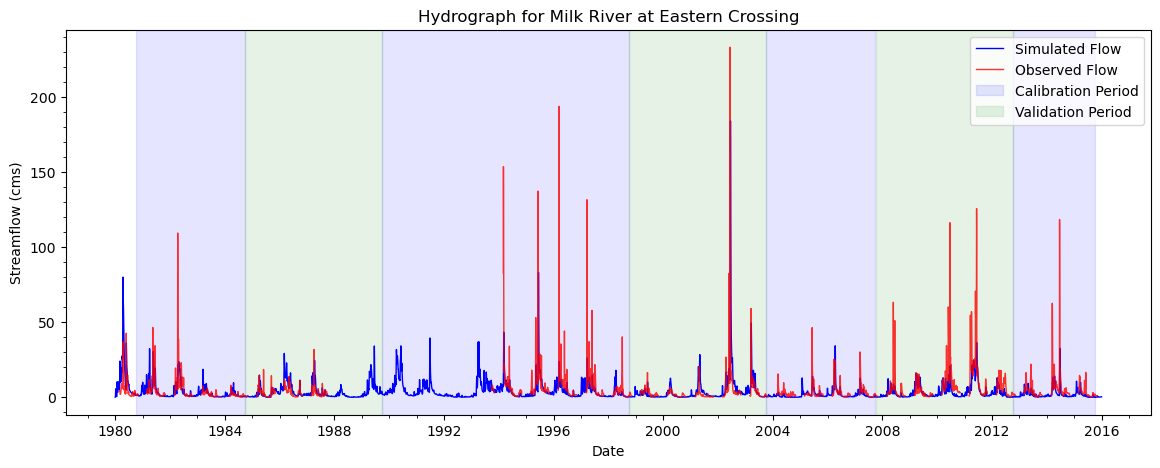

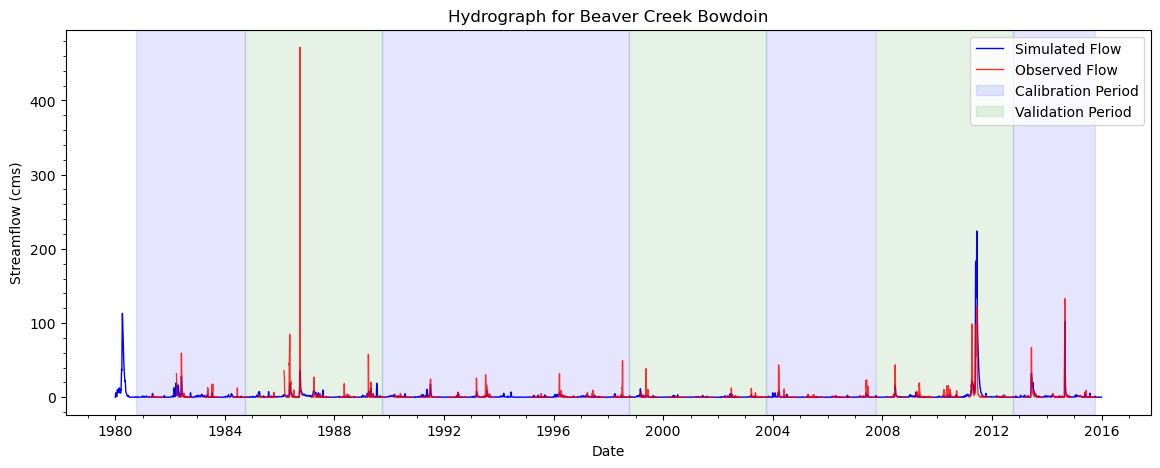

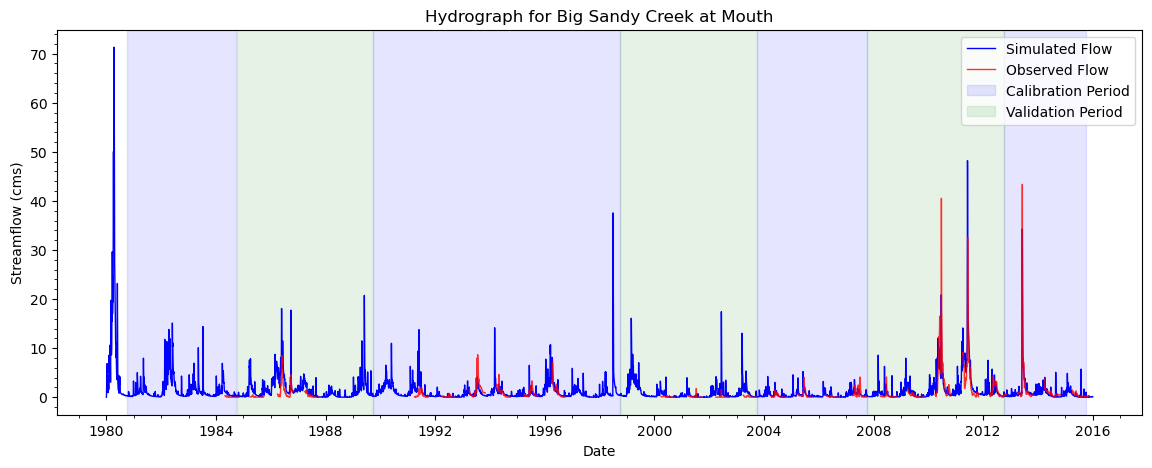

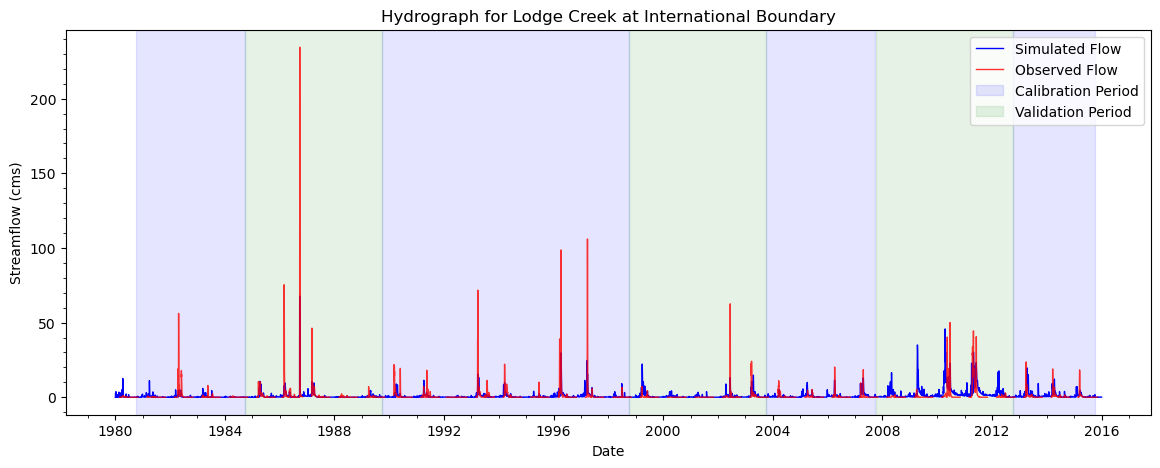

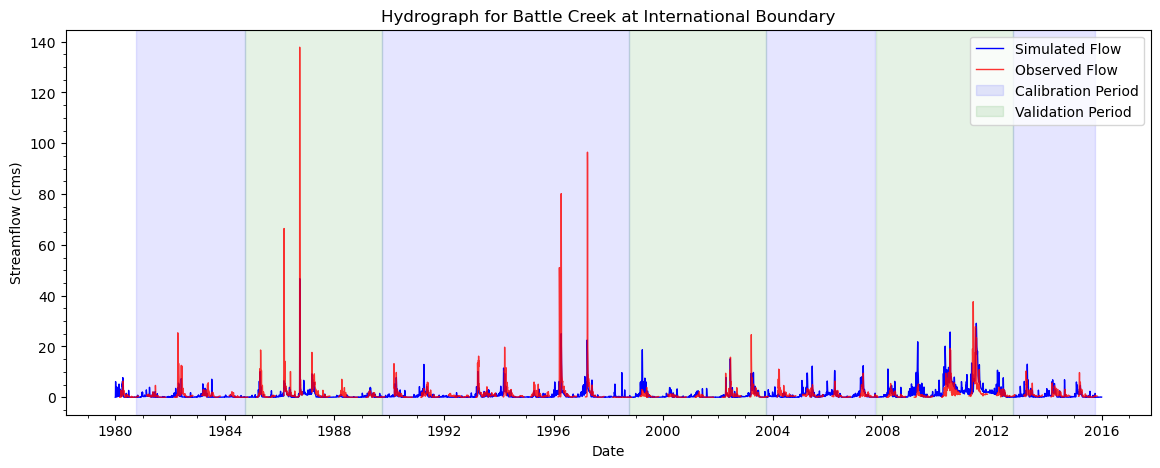

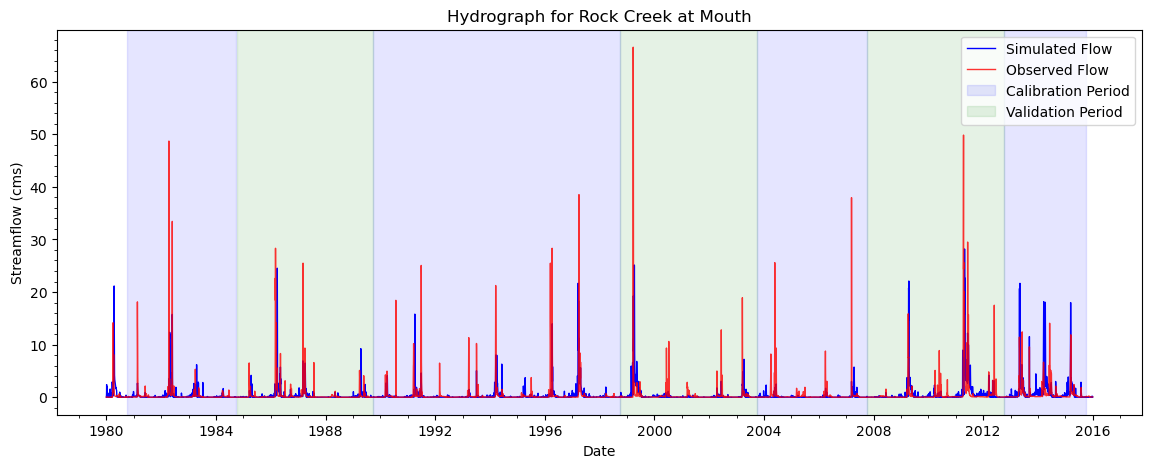

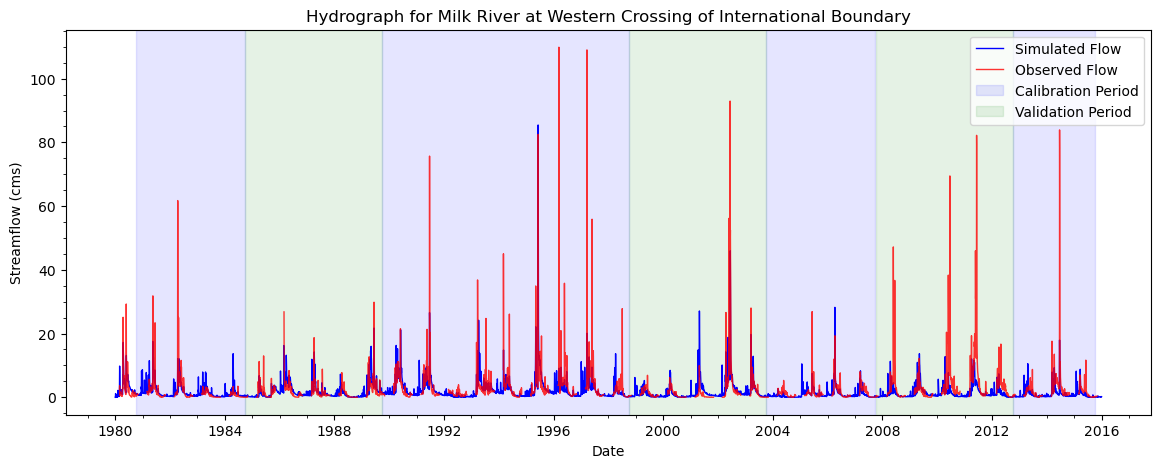

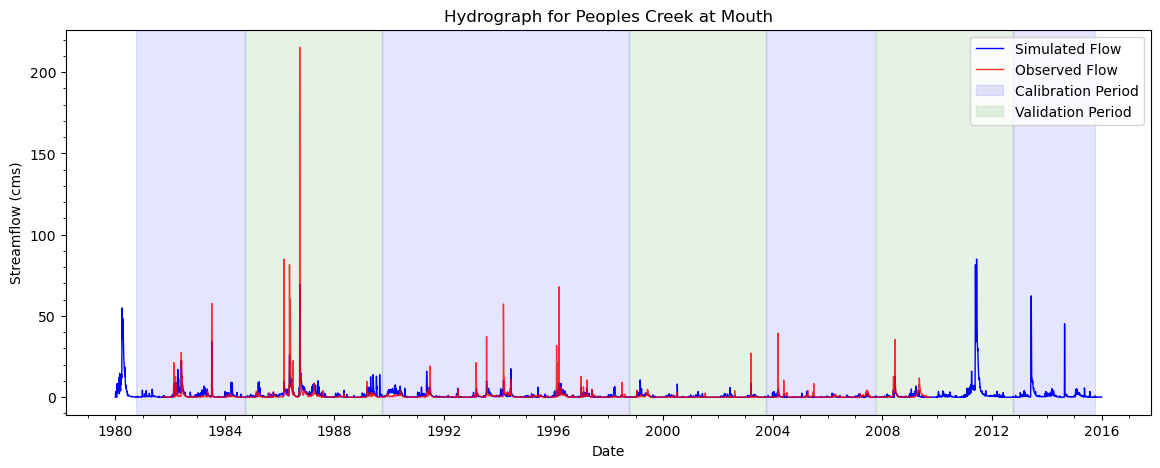

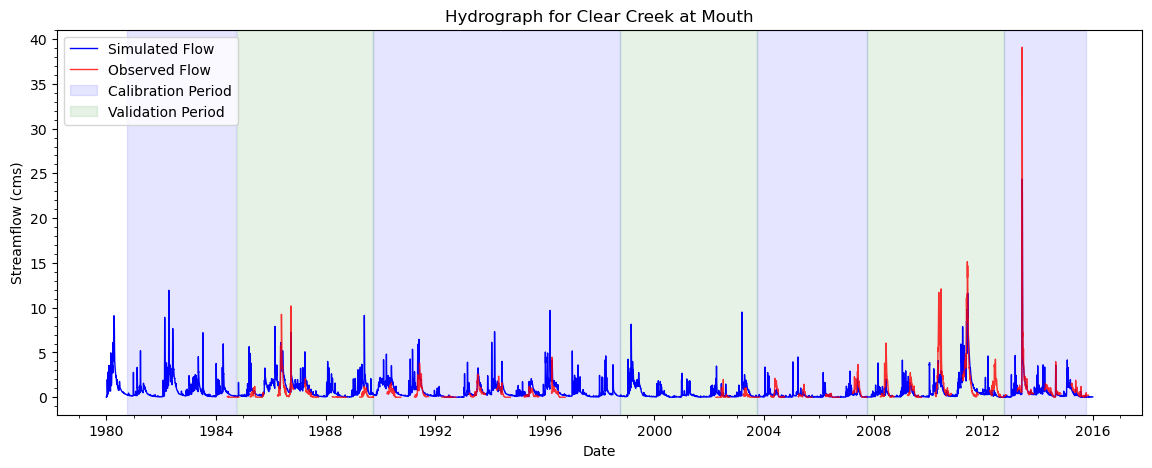

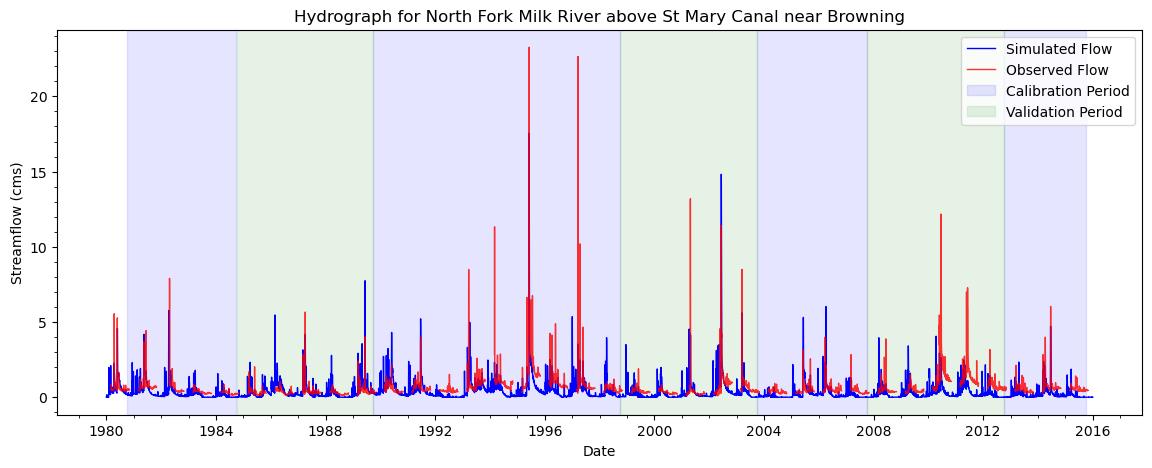

In [4]:
# Iterate through files in the directory
for filename in os.listdir(results_directory):
    if filename.endswith(".txt") and filename.startswith("00"):  # Process files with prefix '00' and end with '.txt'
        filepath = os.path.join(results_directory, filename)
        
        # Extract the number from the filename and remove the leading '00'
        number = re.findall(r'\d+', filename)[0].lstrip('0')  # Removes leading '0's
        
        # Convert number to match the format in the performance_metrics index (if needed)
        hype_id = int(number)  # Convert to int if the index of performance_metrics is integer-based
        
        # Find the corresponding value in performance_metrics and retrieve relevant values
        if hype_id in performance_metrics.index:
            gauge_name = performance_metrics.loc[hype_id, 'Location']
            cal_nse = performance_metrics.loc[hype_id, 'Cal NSE']
            val_nse = performance_metrics.loc[hype_id, 'Val NSE']
            cal_kge = performance_metrics.loc[hype_id, 'Cal KGE']
            val_kge = performance_metrics.loc[hype_id, 'Val KGE']
            cal_bias = performance_metrics.loc[hype_id, 'Cal Bias']
            val_bias = performance_metrics.loc[hype_id, 'Val Bias']
        else:
            gauge_name = 'Unknown'
            cal_nse, val_nse, cal_kge, val_kge = np.nan, np.nan, np.nan, np.nan

        # Read results into dataframe
        flow = pd.read_csv(filepath, index_col=0, sep='\t')
        
        # Drop the first row (assumed header or invalid row)
        flow = flow.drop(flow.index[0])

        # Ensure the index is datetime
        flow.index = pd.to_datetime(flow.index)

        # Convert all columns to float
        flow = flow.astype(float)

        # Replace -9999 with NaN
        flow.replace(-9999, np.nan, inplace=True)

        # Remove rows with NaN values in 'cout' or 'rout'
        flow_clean = flow.dropna(subset=['cout', 'rout'])

        # Calculate R²
        r2 = r2_score(flow_clean['rout'], flow_clean['cout'])

        # Create figure and plot
        fig, ax = plt.subplots(figsize=(14, 5))  # Define ax here to avoid the error
        ax.plot(flow.index, flow['cout'], label='Simulated Flow', alpha=1, linewidth=1, color='blue')
        ax.plot(flow.index, flow['rout'], label='Observed Flow', alpha=0.8, linewidth=1, color='red')

        # Shade calibration periods
        for start, end in calibration_ranges:
            ax.axvspan(start, end, color='blue', alpha=0.1, label='Calibration Period' if start == calibration_ranges[0][0] else "")

        # Shade validation periods
        for start, end in validation_ranges:
            ax.axvspan(start, end, color='green', alpha=0.1, label='Validation Period' if start == validation_ranges[0][0] else "")

        # # Adjust plot limits and layout to make space for the text box
        # plt.subplots_adjust(right=0.75)  # Make space on the right for the text box

        ax.set_xlabel('Date')
        ax.set_ylabel('Streamflow (cms)')
        ax.set_title(f'Hydrograph for {gauge_name}')
        ax.legend()  # Place legend in the upper left to avoid overlap

        # Add minor ticks
        ax.minorticks_on()
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

        # # Add manual box with text for performance metrics, placed outside the plot
        # textstr = (#f'R² = {r2:.2f}\n'
        #            f'Cal NSE = {cal_nse:.2f}\n'
        #            f'Val NSE = {val_nse:.2f}\n'
        #            f'Cal KGE = {cal_kge:.2f}\n'
        #            f'Val KGE = {val_kge:.2f}\n'
        #            f'Cal Bias (%) = {cal_bias:.2f}\n'
        #            f'Cal Bias (%) = {val_bias:.2f}')
        
        # # Place the text box outside the plot to the right
        # plt.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=12,
        #          verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8), clip_on=False)

        # # Save plot as PNG file
        output_filename = f'{filename.split(".")[0]}_hydrograph.png'
        output_path = os.path.join(output_directory, output_filename)
        plt.savefig(output_path)

        plt.show()